# 1. Starter code

In [127]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
torch.manual_seed(42)

In [4]:
names = open("../data/names.txt","r").read().splitlines()

In [70]:
chars = sorted(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [82]:
block_size = 5
def build_dataset(words):
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape,Y.shape)
    return X,Y

In [161]:
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

train_X,train_Y = build_dataset(names[:n1])
val_X,val_Y = build_dataset(names[n1:n2])
test_X,test_Y = build_dataset(names[n2:])

torch.Size([182424, 5]) torch.Size([182424])
torch.Size([22836, 5]) torch.Size([22836])
torch.Size([22886, 5]) torch.Size([22886])


In [55]:
train_X.shape

torch.Size([182441, 5])

In [149]:
class Linear:
    def __init__(self,in_features,out_features,bias=True):
        self.weights = torch.randn((in_features,out_features))/(in_features**0.5)
        # self.name = "Linear"
        if bias:
            self.bias = torch.zeros(out_features)
        else:
            self.bias = None
    def __call__(self,x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def name(self):
        return f'Linear'
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.5):
        self.eps = eps
        # self.name = "BatchNorm1D"
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones (dim)
        self. beta = torch.zeros (dim)
        # buffers (trained with a running 'momentum update')
        self. running_mean = torch.zeros (dim)
        self. running_var = torch.ones (dim)
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self. running_mean
            xvar = self. running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self. beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self. running_mean = (1 - self.momentum) * self. running_mean + self.momentum * xmean
                self. running_var = (1 - self.momentum) * self. running_var + self.momentum * xvar
        return self.out

    def name(self):
        return f'Batch Normalisation'

    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self,x):
        # self.name = "Tanh"
        self.out = torch.tanh(x)
        return self.out
    def name(self):
        return f'Tanh'
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self,vocab_size,n_embedding):
        # self.name = "Embedding"
        self.weights = torch.randn((vocab_size,n_embedding))
    def __call__(self,IX):
        self.out = self.weights[IX]
        return self.out
    def parameters(self):
        return [self.weights]
    def name(self):
        return 'Embedding'

class Flatten:
    def __call__(self,weights):
        self.out = weights.view(weights.shape[0],-1)
        # self.name = "Flatten"
        return self.out
    def name(self):
        return f'Flatten'
    def parameters(self):
        return []
class Sequential:
    def __init__(self,layers:list):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        self.p = [p for layer in self.layers for p in layer.parameters()]
        return self.p

In [150]:
n_emb = 10
n_hidden = 200
vocab_size = len(stoi.keys())

model = Sequential([
    Embedding(vocab_size,n_emb),
    Flatten(),
    Linear(n_emb*block_size,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,vocab_size)
])
# with torch.no_grad():
#     layers[-1].weights *= 1.0
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

16097


In [157]:
epochs = 200000
batch_size = 32
losses = list()
for i in range(epochs):
    ix = torch.randint(0,train_X.shape[0],(batch_size,))
    Xb,Yb = train_X[ix],train_Y[ix]
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)
    losses.append(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    if i%10000 == 0:
        print(f"{i:7d}/{epochs:4d}: {loss.item():.4f}")

      0/200000: 3.5396
  10000/200000: 2.2905
  20000/200000: 2.4494
  30000/200000: 1.9188
  40000/200000: 1.7908
  50000/200000: 2.1338
  60000/200000: 2.0730
  70000/200000: 2.1319
  80000/200000: 2.1675
  90000/200000: 1.7733
 100000/200000: 1.9827
 110000/200000: 1.4374
 120000/200000: 2.0017
 130000/200000: 1.9943
 140000/200000: 1.9053
 150000/200000: 2.0844
 160000/200000: 1.7817
 170000/200000: 2.0885
 180000/200000: 1.7060
 190000/200000: 2.2214


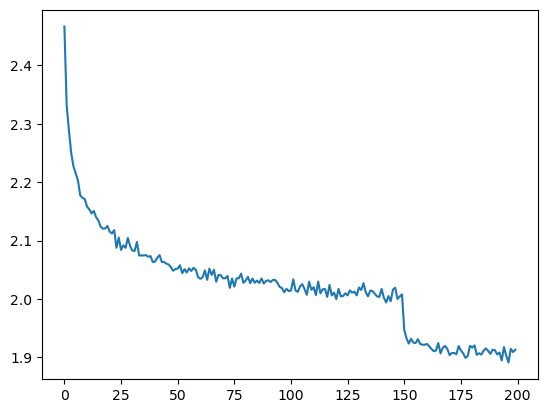

In [158]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [162]:
for layer in model.layers:
    layer.training=False
@torch.no_grad() #this decorator tells torch to turn off gradient tracking for this function
def split_loss(X,y):
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    return loss.item()
print(f"train_loss={split_loss(train_X,train_Y):.4f} \nval_loss={split_loss(val_X,val_Y):.4f} \ntest_loss={split_loss(test_X,test_Y):.4f}")

train_loss=1.9351 
val_loss=1.9444 
test_loss=1.9452


In [156]:
# Sampling:
generator_inference = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=generator_inference).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

cbrpzhxqdbylqvifkwmlpxhtvtyksncfssgojrzhnbnfqpwsvht
igqni
nhztuvpwceziivdvsleggphhbmspoindqbxjtzsnlivwv
vvdbquwqztlogijfryxixfkqeqpiusdtvefcepxip
gtuffjdsfkyoxpqgnovljhksyarnmqqosozswjcojlniycjsfrenqkpwxadlnuo
qoibsvkowazhrxnsq
opklmtnrxa
kxoioloqbhlbvbbdnyypxqmuvtlgbvfpcpdxjpycsiwlqwkkmcf
zauqngjadhq
kbwesdwtvmzamdteffgky
qdyytoorowoottoqkoiokibfcq
zbinhzjs
hu
eoaienkqercqclpwcfzykbadhkklsclc
nqzysdhokhnmh
hzbvvyaslcdhvyocadlwuwc
isawrdfv
kphtzbiuzzsrvgpknbfcyviyuudlddgwmj
pugcnvzhpvdbfppdakrzkxkimtvoocnupnipjmjqjwqvhflwkewtdsrclxdcilvhgfllcuml
hhzc


# 2. Wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
torch.manual_seed(42)

In [2]:
names = open("../data/names.txt","r").read().splitlines()

In [3]:
chars = sorted(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [4]:
block_size = 8
def build_dataset(words):
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape,Y.shape)
    return X,Y

In [5]:
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

train_X,train_Y = build_dataset(names[:n1])
val_X,val_Y = build_dataset(names[n1:n2])
test_X,test_Y = build_dataset(names[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
train_X.shape

torch.Size([182625, 8])

In [29]:
class Linear:
    def __init__(self,in_features,out_features,bias=True):
        self.weights = torch.randn((in_features,out_features))/(in_features**0.5)
        self.name = "Linear"
        if bias:
            self.bias = torch.zeros(out_features)
        else:
            self.bias = None
    def __call__(self,x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.5):
        self.eps = eps
        self.name = "BatchNorm1D"
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones (dim)
        self. beta = torch.zeros (dim)
        # buffers (trained with a running 'momentum update')
        self. running_mean = torch.zeros (dim)
        self. running_var = torch.ones (dim)
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self. running_mean
            xvar = self. running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self. beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self. running_mean = (1 - self.momentum) * self. running_mean + self.momentum * xmean
                self. running_var = (1 - self.momentum) * self. running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __init__(self):
        self.name = "Tanh"
        pass
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self,vocab_size,n_embedding):
        self.name = "Embedding"
        self.weights = torch.randn((vocab_size,n_embedding))
    def __call__(self,IX):
        self.out = self.weights[IX]
        return self.out
    def parameters(self):
        return [self.weights]
    

class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
        self.name = "Flatten"

    def __call__(self,weights):
        B,T,C = weights.shape
        x = weights.view(B,T//self.n,C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out  = x
        return self.out
    
    def parameters(self):
        return []
class Sequential:
    def __init__(self,layers:list):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        self.p = [p for layer in self.layers for p in layer.parameters()]
        return self.p

In [30]:
n_emb = 10
n_hidden = 200
vocab_size = len(stoi.keys())

model = Sequential([
    Embedding(vocab_size,n_emb),
    FlattenConsecutive(2), Linear(n_emb*2,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,vocab_size)
])
with torch.no_grad():
    model.layers[-1].weights *= 1.0
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [31]:
for layer in model.layers:
    print(layer.name)

Embedding
Flatten
Linear
BatchNorm1D
Tanh
Flatten
Linear
BatchNorm1D
Tanh
Flatten
Linear
BatchNorm1D
Tanh
Linear


In [33]:
epochs = 200000
batch_size = 32
losses = list()
for i in range(epochs):
    ix = torch.randint(0,train_X.shape[0],(batch_size,))
    Xb,Yb = train_X[ix],train_Y[ix]
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)
    losses.append(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    if i%10000 == 0:
        print(f"{i:7d}/{epochs:4d}: {loss.item():.4f}")

      0/200000: 3.1596
  10000/200000: 2.1845
  20000/200000: 2.4337
  30000/200000: 1.7942
  40000/200000: 2.2973
  50000/200000: 1.5440
  60000/200000: 2.3392
  70000/200000: 2.0731
  80000/200000: 2.3116
  90000/200000: 2.2222
 100000/200000: 2.1009
 110000/200000: 1.9772
 120000/200000: 1.5323
 130000/200000: 1.7836
 140000/200000: 1.6763
 150000/200000: 2.1051
 160000/200000: 1.8211
 170000/200000: 1.7664
 180000/200000: 1.7517
 190000/200000: 1.5921


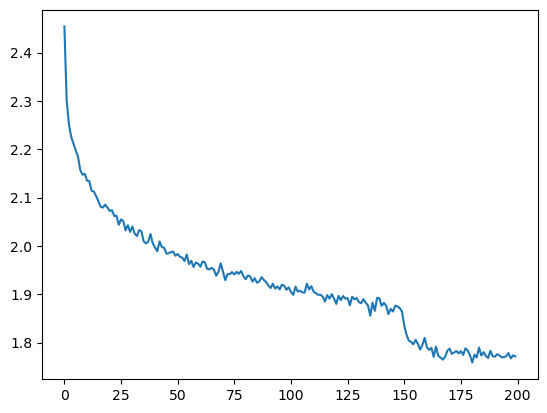

In [34]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [35]:
for layer in model.layers:
    layer.training=False
@torch.no_grad() #this decorator tells torch to turn off gradient tracking for this function
def split_loss(X,y):
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    return loss.item()
print(f"train_loss={split_loss(train_X,train_Y):.4f} \nval_loss={split_loss(val_X,val_Y):.4f} \ntest_loss={split_loss(test_X,test_Y):.4f}")

train_loss=1.7432 
val_loss=2.0004 
test_loss=1.9972


In [12]:
# Sampling:
generator_inference = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=generator_inference).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

carmah
amelle
khirmle
reety
halani
ejance
nadeely
charqui
nermair
chaiir
kaleigh
hamondi
desir
zaroi
emiliana
wazell
dearyn
kailee
ivrah
edde
